In [ ]:
!pip install tensorflow==2.3.0
!pip install onnx==1.9.0
!pip install keras2onnx==1.7.0

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import onnx
import keras2onnx

In [3]:
"""
Datasets used:
https://www.kaggle.com/c/dogs-vs-cats/data
https://www.kaggle.com/shamsaddin97/image-captioning-dataset-random-images
https://www.kaggle.com/iamsouravbanerjee/animal-image-dataset-90-different-animals
"""

train_path = '/content/drive/MyDrive/dataset/train'
valid_path = '/content/drive/MyDrive/dataset/validation'
test_path = '/content/drive/MyDrive/dataset/test'


Found 7500 files belonging to 3 classes.


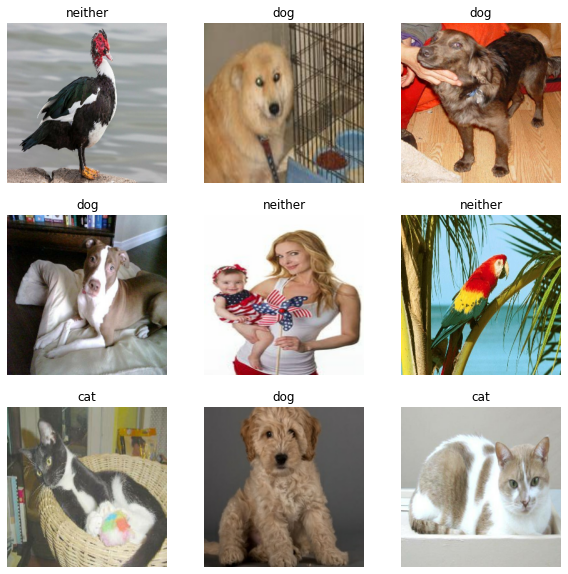

In [4]:
train_set = image_dataset_from_directory(train_path)

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_set.class_names[labels[i]])
        plt.axis("off")

In [5]:
train_batches = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input).flow_from_directory(directory=train_path, 
                                                                 target_size=(224,224), 
                                                                 batch_size=16)

valid_batches = ImageDataGenerator(
    preprocessing_function=preprocess_input).flow_from_directory(directory=valid_path, 
                                                                 target_size=(224,224), 
                                                                 batch_size=16)

test_batches = ImageDataGenerator(
    preprocessing_function=preprocess_input).flow_from_directory(directory=test_path, 
                                                                 target_size=(224,224), 
                                                                 batch_size=16)

Found 7500 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [6]:
base_model = MobileNet(include_top=False)

In [7]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [8]:
for layer in base_model.layers[:-3]: # train last ~1M parameters to fine-tune high-level representations
  layer.trainable = False

In [9]:
x = base_model.layers[-1].output
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.2)(x)
outputs = Dense(units=3, activation="softmax")(x)

In [10]:
model = Model(base_model.inputs, outputs)

In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

In [12]:
model.compile(optimizer=Adam(lr=0.0001), 
              loss="categorical_crossentropy", 
              metrics=['accuracy'])

In [13]:
model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10)

Epoch 1/10
469/469 [==============================] - 164s 350ms/step - loss: 0.3436 - accuracy: 0.8663 - val_loss: 0.1057 - val_accuracy: 0.9638
Epoch 2/10
469/469 [==============================] - 165s 353ms/step - loss: 0.1811 - accuracy: 0.9323 - val_loss: 0.0813 - val_accuracy: 0.9721
Epoch 3/10
469/469 [==============================] - 168s 358ms/step - loss: 0.1542 - accuracy: 0.9425 - val_loss: 0.0791 - val_accuracy: 0.9729
Epoch 4/10
469/469 [==============================] - 161s 343ms/step - loss: 0.1287 - accuracy: 0.9528 - val_loss: 0.0672 - val_accuracy: 0.9771
Epoch 5/10
469/469 [==============================] - 162s 345ms/step - loss: 0.1152 - accuracy: 0.9564 - val_loss: 0.0711 - val_accuracy: 0.9771
Epoch 6/10
469/469 [==============================] - 160s 341ms/step - loss: 0.0954 - accuracy: 0.9655 - val_loss: 0.0590 - val_accuracy: 0.9787
Epoch 7/10
469/469 [==============================] - 162s 345ms/step - loss: 0.0993 - accuracy: 0.9635 - val_loss: 0.0726 -

In [14]:
model.evaluate(x=test_batches)

75/75 [==============================] - 11s 151ms/step - loss: 0.0699 - accuracy: 0.9767


[0.06989936530590057, 0.9766666889190674]

In [15]:
onnx_model = keras2onnx.convert_keras(model, model.name)
with open("fine_tuned_mobilenet.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 244 -> 61
